In [1]:
%matplotlib inline

In [2]:
import numpy as np
import datetime
from flixOpt.elements import Flow, Bus, Effect
from flixOpt.components import Boiler, Source, Sink
from flixOpt.flow_system import FlowSystem
from flixOpt.calculation import FullCalculation

# Creating Data for Modeling ##
Data can of course be read from files, but for this example we will create some data.

In [3]:
Q_th_Last = np.array([30., 0., 20.]) # kW; thermal load profile in kW
datetime_series = datetime.datetime(2020, 1, 1) +  np.arange(len(Q_th_Last)) * datetime.timedelta(hours=1) # creating timeseries with 1 hour steps
datetime_series = datetime_series.astype('datetime64') # needed format for timeseries in flixOpt
print(datetime_series)

['2020-01-01T00:00:00.000000' '2020-01-01T01:00:00.000000'
 '2020-01-01T02:00:00.000000']


## Bus-Definition: ##
For this example, we will use a single bus for gas and heat.

In [4]:
fernwaerme = Bus('heat', 'Fernwärme') # balancing node/bus of heat
gas = Bus('fuel', 'Gas') # balancing node/bus of gas

label='Fernwärme' doesnt allign with name restrictions and is changed to new_label='Fernwaerme'


## Effect-Definition: ##
We will use costs as our optimization target. No other effects are used in this example

In [5]:
costs = Effect('costs','€','Kosten',  # name, unit, description
                    is_standard = True, # standard effect --> shorter input possible (without effect as a key)
                    is_objective = True) # defining costs as objective of optimiziation

## Component-Definition: ##
Now we define the components of our flow_system.
For our most basic flow_system, we define a Boiler, a Heat Demand and a Gas Source.
We connect them by connecting each input and output to one of the buses

In [6]:
boiler = Boiler('Boiler', eta = 0.5, # name, efficiency factor
                  # defining the output-flow = thermal -flow
                  Q_th = Flow(label = 'Q_th', # name of flow
                               bus = fernwaerme, # define, where flow is linked to (here: Fernwaerme-Bus)
                               size=50, # kW; size of boiler
                               ),    
                  # defining the input-flow = fuel-flow
                  Q_fu = Flow(label = 'Q_fu', # name of flow
                               bus = gas # define, where flow is linked to (here: Gas-Bus)
                              ) 
                  )

# sink of heat load:
waermelast = Sink('Wärmelast',
                    # defining input-flow:
                    sink = Flow('Q_th_Last', # name
                                   bus = fernwaerme, # linked to bus "Fernwaerme"
                                   size=1, # size
                                   fixed_relative_value = Q_th_Last   # fixed profile
                                  )
                  ) 
    
# source of gas:
gastarif = Source('Gastarif' ,
                    # defining output-flow:
                    source = Flow('Q_Gas', # name
                                   bus = gas, # linked to bus "Gas"
                                   size = 1000, # nominal size, i.e. 1000 kW maximum
                                   # defining effect-shares. 
                                   #    Here not only "costs", but also CO2-emissions:
                                   effects_per_flow_hour= 0.04)) # 0.04 €/kWh


label='Wärmelast' doesnt allign with name restrictions and is changed to new_label='Waermelast'


## Build energysystem - Registering of all elements ##
Finally, we bring all elements together into an energysystem.
After that, we use the System to perform a calculation. There are multiple types of calculations to choose from. We choose the bbais one, as there is no need for this simle flow_system.

In [8]:
# 1. Create System and add Elements:
flow_system = FlowSystem(datetime_series, last_time_step_hours=None) # creating flow_system, (duration of last timestep is like the one before)
flow_system.add_effects(costs) # adding defined effects
flow_system.add_components(boiler, waermelast, gastarif) # adding components

# 2. Create a Calculation
calculation = FullCalculation('Sim1', # name of calculation
                     flow_system, # energysystem to calculate
                     'pyomo', # optimization modeling language (only "pyomo" implemented, yet)
                     None) # used time steps, if None, use all timesteps

# 3. modeling:
calculation.do_modeling() # mathematical modeling of flow_system

# 3a. (optional) print Model-Characteristics:
flow_system.printModel() # string-output:network structure of model
flow_system.print_variables() # string output: variables of model
flow_system.print_equations() # string-output: equations of model


### some Solver-Inputs: ###
solverProps = {'mip_gap': 0.01,   # solver-gap
               'time_limit_seconds': 3600,   # choose the solver, you have installed
               'solver_name': 'highs',   # Choose your installed solver (highs is preinstalled)
               'solver_output_to_console': True,   # print solver-output to console
               }

calculation.solve(solverProps)   # results are saved under /results/ if nothing else is specified

Register new effect costs
Register new Component Boiler
Register new Component Waermelast
Register new Component Gastarif
finalize all Elements...
Boiler
Waermelast
Gastarif
Fernwaerme
Gas
Objective
Effects
Q_th
Q_fu
Q_th_Last
Q_Gas
modeling costs
declare_vars_and_eqs Q_fu
declare_vars_and_eqs Q_th
declare_vars_and_eqs Q_th_Last
declare_vars_and_eqs Q_Gas

##############################################################
########## Short String Description of Energysystem ##########

buses:
  Fernwaerme:
    In-Flows:
    - Q_th:
        comp: Boiler
    - Q_th:
        comp: Boiler
    Out-Flows:
    - Q_th_Last:
        comp: Waermelast
    - Q_th_Last:
        comp: Waermelast
    class: Bus
  Gas:
    In-Flows:
    - Q_Gas:
        comp: Gastarif
    - Q_Gas:
        comp: Gastarif
    Out-Flows:
    - Q_fu:
        comp: Boiler
    - Q_fu:
        comp: Boiler
    class: Bus
components:
  Boiler:
    In-Flows:
    - Q_fu:
        bus: Gas
    Out-Flows:
    - Q_th:
        bus: Fernw

# Loading results:


In [11]:
import flixOpt.flixPostprocessing as flixPost

results = flixPost.flix_results(calculation.name)

print(f"{results.results['Boiler']['Q_th']['val']=}", end="\n\n")
print(f"{results.results['Gastarif']['Q_Gas']['val']=}", end="\n\n")
print(f"Fernwaerme-Bus:\n"
      f"{results.to_dataFrame('Fernwaerme', 'inout')}")

results.results['Boiler']['Q_th']['val']=array([30., -0., 20.])

results.results['Gastarif']['Q_Gas']['val']=array([60.,  0., 40.])

Fernwaerme-Bus:
                     Boiler__Q_th  Waermelast__Q_th_Last
2020-01-01 00:00:00          30.0                   30.0
2020-01-01 01:00:00          -0.0                    0.0
2020-01-01 02:00:00          20.0                   20.0


# Plotting some results

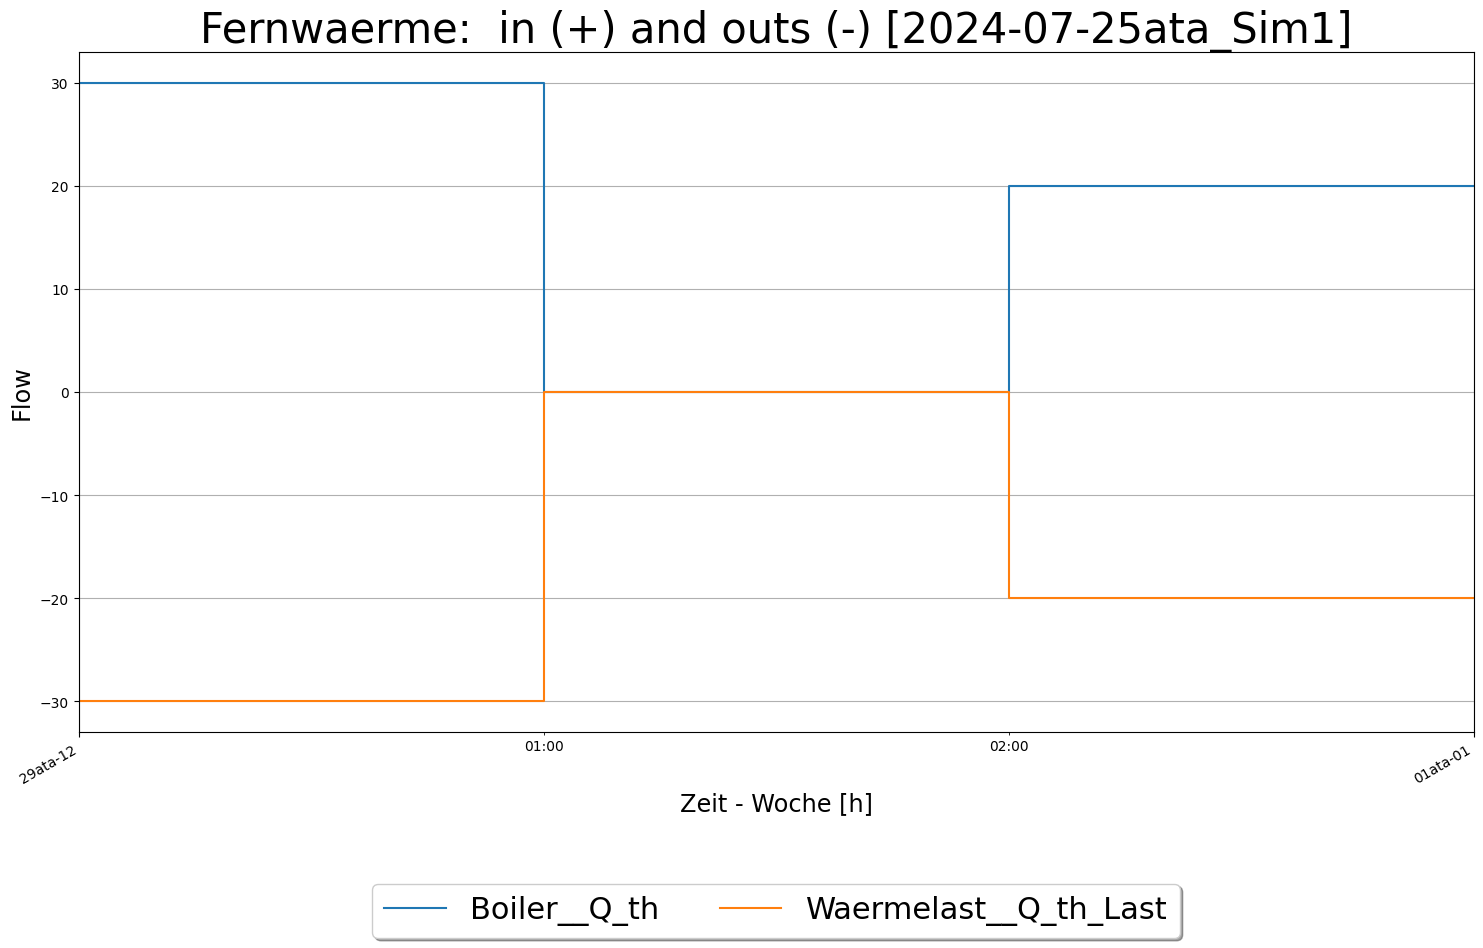

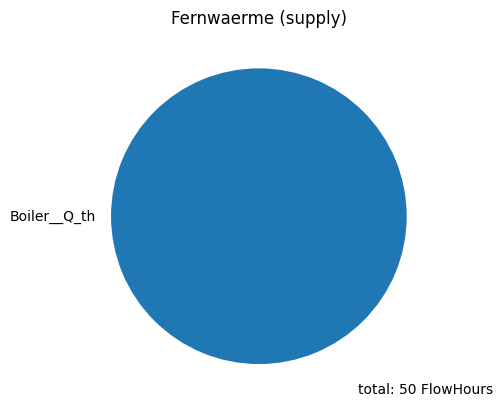

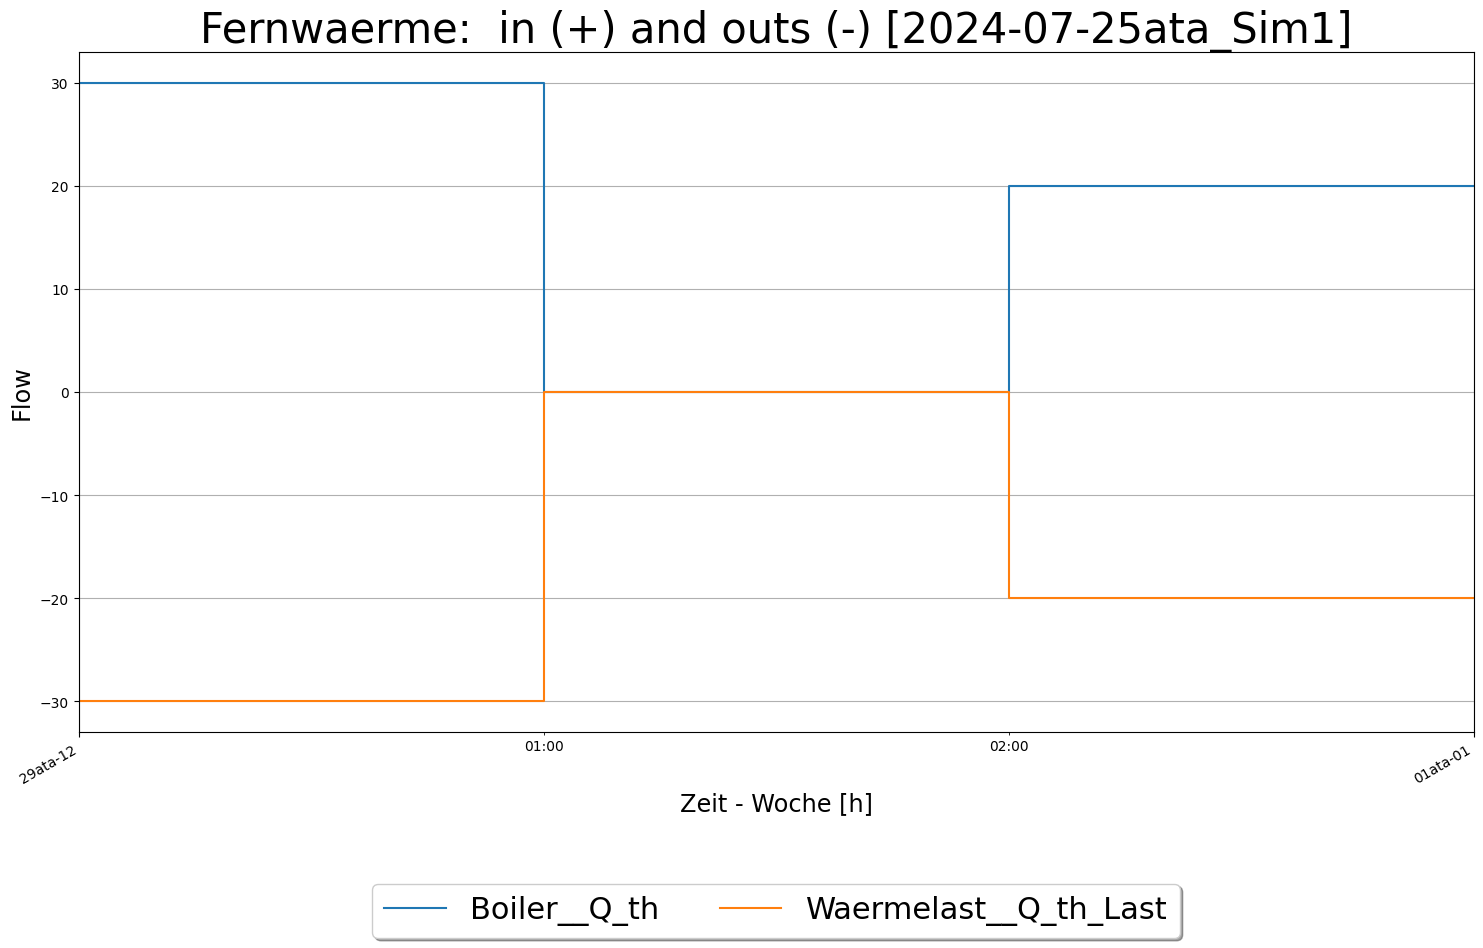

In [12]:
results.plotShares('Fernwaerme')
results.plotInAndOuts('Fernwaerme')